### b) Use Vanilla RNN with hidden_dimension=64, followed by Global maxpool 1d, followed by FC with 16 neurons with ReLU, followed by FC layer with single output with sigmoid function.

In [8]:
import pandas as pd
import re
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pandas as pd
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# List of encodings to try
encodings_to_try = ['utf-8', 'latin1', 'iso-8859-1']

for encoding in encodings_to_try:
    try:
        df = pd.read_csv("IMDB_Dataset.csv", encoding=encoding)
        break  # Break the loop if successful
    except UnicodeDecodeError:
        print("Failed to read with encoding '{}'".format(encoding))
        continue

# Display the first few rows of the DataFrame
df.head()

# Cleaning up the text
nltk.download("stopwords")
stopWords = set(nltk.corpus.stopwords.words("english"))

def CleanText(text):
    text = text.lower() 
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopWords]
    text = " ".join(words)
    return text

df["review"] = df.apply(lambda row: CleanText(row["review"]), axis=1)
Data = df.review
labels = df.sentiment

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:


# Convert labels to numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Convert text data to sequences
frequentWord = 10000
tokenizer = Tokenizer(num_words=frequentWord)
tokenizer.fit_on_texts(Data)
IntegerizedData = tokenizer.texts_to_sequences(Data)

# Zero padding
maxlen = 256
IntegerizedData = pad_sequences(IntegerizedData, maxlen=maxlen)


In [10]:
# Train-validation-test split
x_train_val, x_test, y_train_val, y_test = train_test_split(IntegerizedData, labels, stratify=labels, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify=y_train_val, test_size=0.10, random_state=42)


# BEST ONE TO CONSIDER

Epoch 1/70, Loss: 0.6931, Validation Loss: 0.6928, Train Accuracy: 0.5076, Validation Accuracy: 0.5165
Epoch 2/70, Loss: 0.6925, Validation Loss: 0.6919, Train Accuracy: 0.5303, Validation Accuracy: 0.5467
Epoch 3/70, Loss: 0.6909, Validation Loss: 0.6897, Train Accuracy: 0.5947, Validation Accuracy: 0.6438
Epoch 4/70, Loss: 0.6882, Validation Loss: 0.6860, Train Accuracy: 0.6327, Validation Accuracy: 0.6767
Epoch 5/70, Loss: 0.6829, Validation Loss: 0.6788, Train Accuracy: 0.6859, Validation Accuracy: 0.7077
Epoch 6/70, Loss: 0.6737, Validation Loss: 0.6671, Train Accuracy: 0.6974, Validation Accuracy: 0.7083
Epoch 7/70, Loss: 0.6599, Validation Loss: 0.6508, Train Accuracy: 0.7138, Validation Accuracy: 0.7120
Epoch 8/70, Loss: 0.6412, Validation Loss: 0.6289, Train Accuracy: 0.7197, Validation Accuracy: 0.7160
Epoch 9/70, Loss: 0.6157, Validation Loss: 0.6002, Train Accuracy: 0.7307, Validation Accuracy: 0.7222
Epoch 10/70, Loss: 0.5844, Validation Loss: 0.5676, Train Accuracy: 0.744

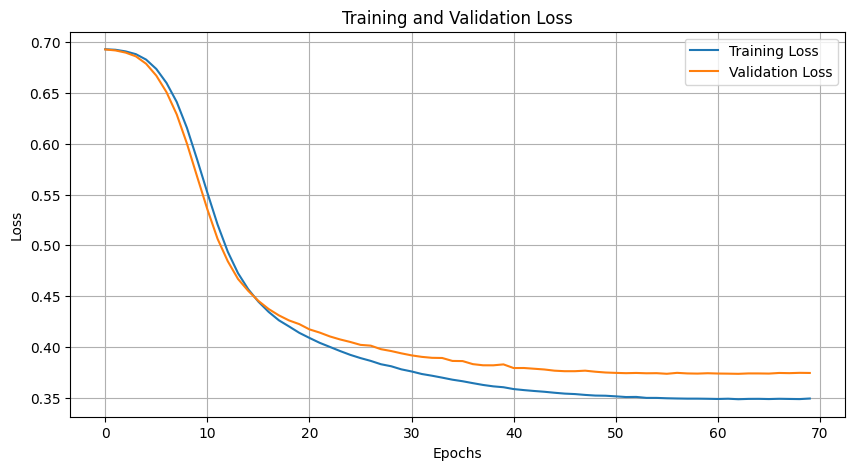

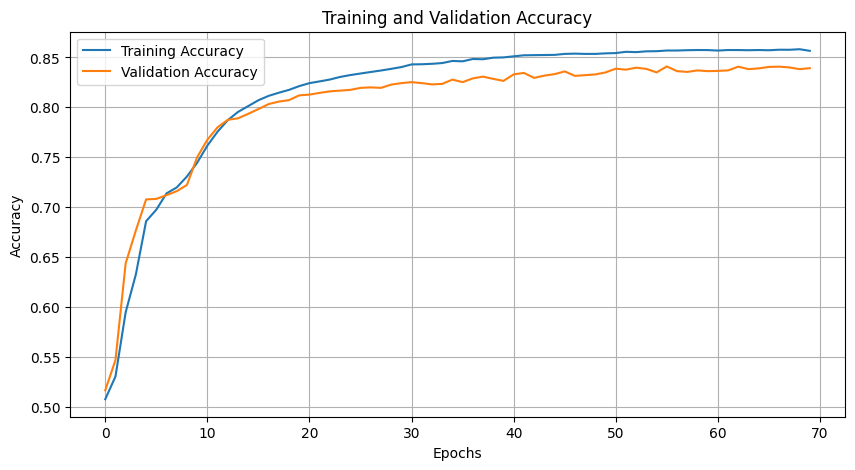

In [23]:
# Set hyperparameters
input_size = frequentWord
embedding_dim = 64
hidden_size = 64
output_size = 1  
learning_rate = 0.0001
weight_decay = 11e-3  
dropout = 0.5  
batch_size = 256
num_epochs = 70

# Instantiate the model and move to device
model = VanillaRNN(input_size, embedding_dim, hidden_size, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# PREVIOUS ATTEMPTS

Epoch 1/85, Loss: 0.6927, Validation Loss: 0.6921, Train Accuracy: 0.5255, Validation Accuracy: 0.5600
Epoch 2/85, Loss: 0.6913, Validation Loss: 0.6902, Train Accuracy: 0.5696, Validation Accuracy: 0.6178
Epoch 3/85, Loss: 0.6886, Validation Loss: 0.6864, Train Accuracy: 0.6145, Validation Accuracy: 0.6835
Epoch 4/85, Loss: 0.6805, Validation Loss: 0.6680, Train Accuracy: 0.6854, Validation Accuracy: 0.6907
Epoch 5/85, Loss: 0.6460, Validation Loss: 0.6218, Train Accuracy: 0.7197, Validation Accuracy: 0.7302
Epoch 6/85, Loss: 0.6001, Validation Loss: 0.5799, Train Accuracy: 0.7377, Validation Accuracy: 0.7345
Epoch 7/85, Loss: 0.5589, Validation Loss: 0.5427, Train Accuracy: 0.7524, Validation Accuracy: 0.7545
Epoch 8/85, Loss: 0.5229, Validation Loss: 0.5131, Train Accuracy: 0.7665, Validation Accuracy: 0.7648
Epoch 9/85, Loss: 0.4934, Validation Loss: 0.4918, Train Accuracy: 0.7788, Validation Accuracy: 0.7682
Epoch 10/85, Loss: 0.4691, Validation Loss: 0.4718, Train Accuracy: 0.790

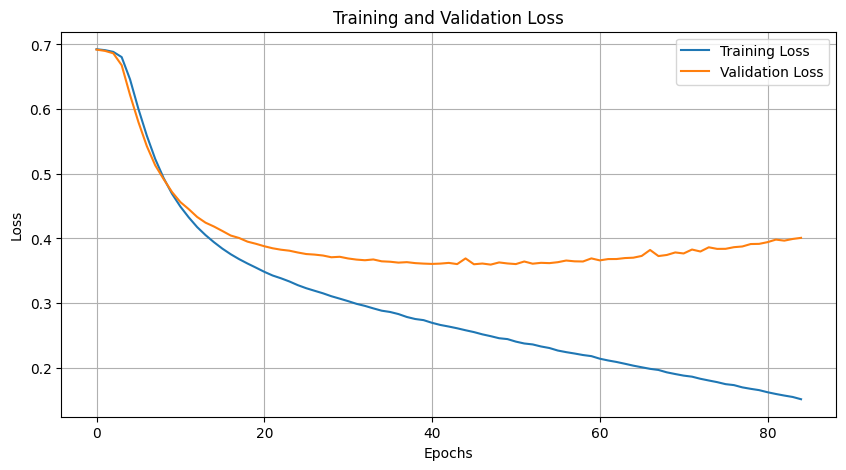

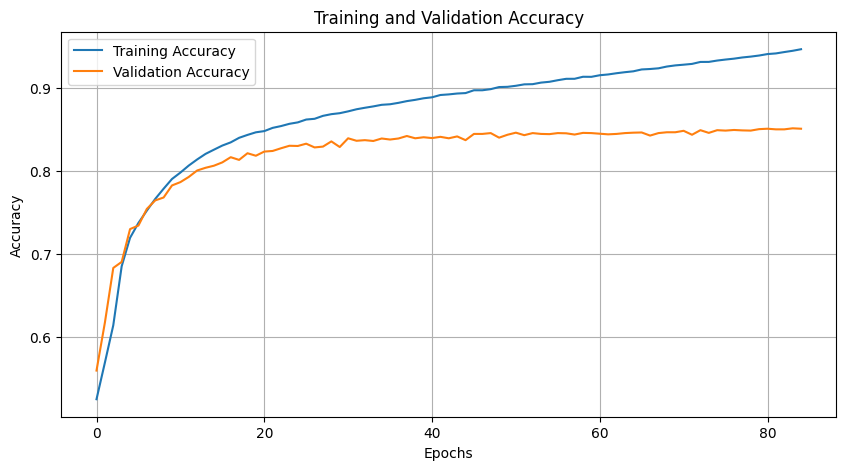

In [5]:


# Convert data to PyTorch tensors and move to device
x_train = torch.tensor(x_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
x_val = torch.tensor(x_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
x_test = torch.tensor(x_test, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Define the Vanilla RNN model
class VanillaRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_classes):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.pool = nn.AdaptiveMaxPool1d(1)  # Global max pooling
        self.fc1 = nn.Linear(hidden_size, 16)  # First FC layer
        self.fc2 = nn.Linear(16, num_classes)  # Second FC layer (output)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        # Apply global max pooling to the outputs of the RNN across the sequence
        x = x.permute(0, 2, 1)  # Reshape for pooling layer
        x = self.pool(x).squeeze(-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)
        
# Set hyperparameters
input_size = frequentWord
embedding_dim = 64
hidden_size = 64
output_size = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.0001
weight_decay = 6e-5
dropout = 0.5
batch_size = 256
num_epochs = 85

# Instantiate the model and move to device
model = VanillaRNN(input_size, embedding_dim, hidden_size, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Data loaders
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))

# Test the model
model.eval()
test_accuracy = 0.0
with torch.no_grad():
    correct_test_predictions = 0
    total_test_predictions = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        preds = torch.round(outputs.squeeze())
        correct_test_predictions += torch.sum(preds == labels).item()
        total_test_predictions += labels.size(0)
    test_accuracy = correct_test_predictions / total_test_predictions

print("Test Accuracy: {:.4f}".format(test_accuracy))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/85, Loss: 0.6926, Validation Loss: 0.6923, Train Accuracy: 0.5154, Validation Accuracy: 0.5072
Epoch 2/85, Loss: 0.6910, Validation Loss: 0.6905, Train Accuracy: 0.5598, Validation Accuracy: 0.5703
Epoch 3/85, Loss: 0.6888, Validation Loss: 0.6884, Train Accuracy: 0.5899, Validation Accuracy: 0.5370
Epoch 4/85, Loss: 0.6850, Validation Loss: 0.6827, Train Accuracy: 0.6504, Validation Accuracy: 0.6145
Epoch 5/85, Loss: 0.6703, Validation Loss: 0.6538, Train Accuracy: 0.6874, Validation Accuracy: 0.7120
Epoch 6/85, Loss: 0.6284, Validation Loss: 0.6039, Train Accuracy: 0.7097, Validation Accuracy: 0.7117
Epoch 7/85, Loss: 0.5776, Validation Loss: 0.5615, Train Accuracy: 0.7261, Validation Accuracy: 0.7392
Epoch 8/85, Loss: 0.5349, Validation Loss: 0.5215, Train Accuracy: 0.7492, Validation Accuracy: 0.7510
Epoch 9/85, Loss: 0.4999, Validation Loss: 0.4923, Train Accuracy: 0.7688, Validation Accuracy: 0.7592
Epoch 10/85, Loss: 0.4728, Validation Loss: 0.4700, Train Accuracy: 0.783

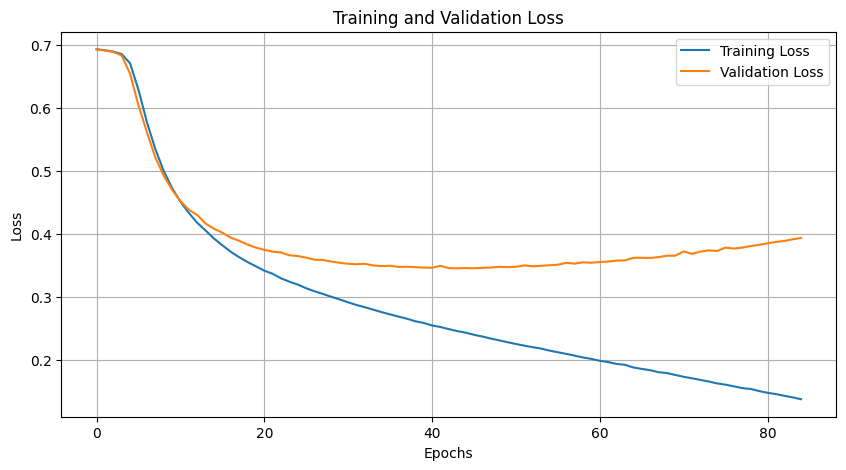

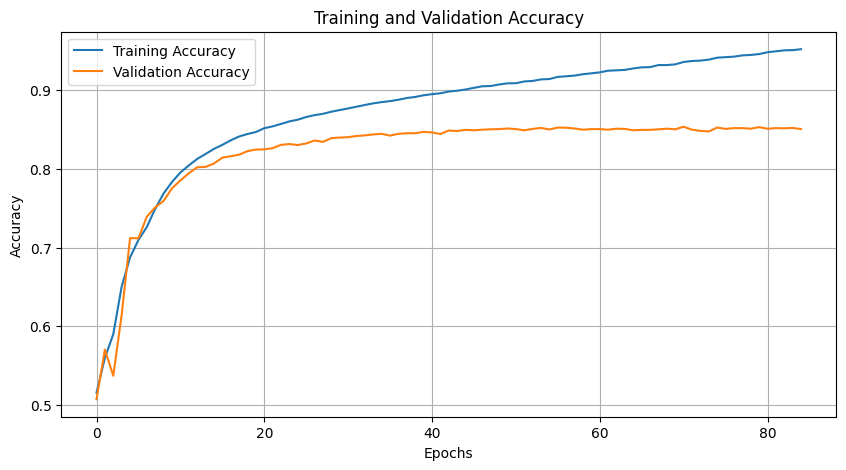

In [17]:
# Set hyperparameters
input_size = frequentWord
embedding_dim = 64
hidden_size = 64
output_size = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.0001
weight_decay = 5e-5  # Adjust weight decay here
dropout = 0.5  # Adjust dropout rate here
batch_size = 256
num_epochs = 85

# Instantiate the model and move to device
model = VanillaRNN(input_size, embedding_dim, hidden_size, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/85, Loss: 0.6966, Validation Loss: 0.6925, Train Accuracy: 0.5039, Validation Accuracy: 0.5447
Epoch 2/85, Loss: 0.6921, Validation Loss: 0.6915, Train Accuracy: 0.5609, Validation Accuracy: 0.5905
Epoch 3/85, Loss: 0.6908, Validation Loss: 0.6896, Train Accuracy: 0.5860, Validation Accuracy: 0.6218
Epoch 4/85, Loss: 0.6869, Validation Loss: 0.6798, Train Accuracy: 0.6245, Validation Accuracy: 0.6385
Epoch 5/85, Loss: 0.6670, Validation Loss: 0.6507, Train Accuracy: 0.6339, Validation Accuracy: 0.6535
Epoch 6/85, Loss: 0.6470, Validation Loss: 0.6331, Train Accuracy: 0.6434, Validation Accuracy: 0.6667
Epoch 7/85, Loss: 0.6314, Validation Loss: 0.6192, Train Accuracy: 0.6566, Validation Accuracy: 0.6747
Epoch 8/85, Loss: 0.6198, Validation Loss: 0.6142, Train Accuracy: 0.6661, Validation Accuracy: 0.6723
Epoch 9/85, Loss: 0.6078, Validation Loss: 0.5978, Train Accuracy: 0.6819, Validation Accuracy: 0.6883
Epoch 10/85, Loss: 0.5976, Validation Loss: 0.5866, Train Accuracy: 0.687

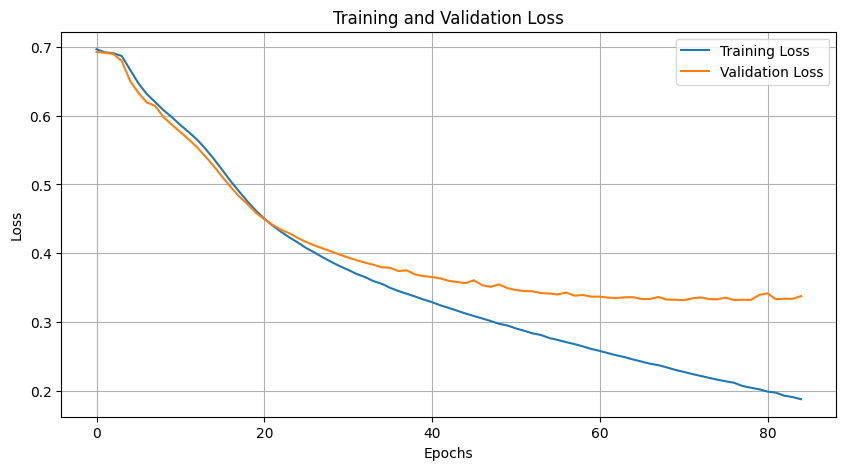

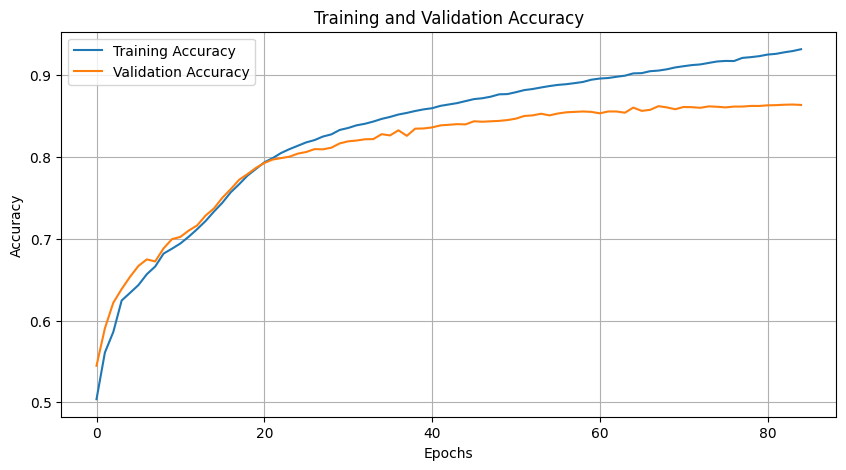

In [16]:
# Set hyperparameters
input_size = frequentWord
embedding_dim = 64
hidden_size = 64
output_size = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.0001
weight_decay = 9e-5  # Adjust weight decay here
dropout = 0.5  # Adjust dropout rate here
batch_size = 256
num_epochs = 85

# Instantiate the model and move to device
model = VanillaRNN(input_size, embedding_dim, hidden_size, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/85, Loss: 0.6964, Validation Loss: 0.6921, Train Accuracy: 0.5081, Validation Accuracy: 0.5610
Epoch 2/85, Loss: 0.6913, Validation Loss: 0.6903, Train Accuracy: 0.5845, Validation Accuracy: 0.6395
Epoch 3/85, Loss: 0.6890, Validation Loss: 0.6875, Train Accuracy: 0.6229, Validation Accuracy: 0.6505
Epoch 4/85, Loss: 0.6854, Validation Loss: 0.6826, Train Accuracy: 0.6754, Validation Accuracy: 0.6897
Epoch 5/85, Loss: 0.6776, Validation Loss: 0.6692, Train Accuracy: 0.7022, Validation Accuracy: 0.7100
Epoch 6/85, Loss: 0.6474, Validation Loss: 0.6244, Train Accuracy: 0.6851, Validation Accuracy: 0.6920
Epoch 7/85, Loss: 0.6058, Validation Loss: 0.5844, Train Accuracy: 0.7098, Validation Accuracy: 0.7242
Epoch 8/85, Loss: 0.5655, Validation Loss: 0.5449, Train Accuracy: 0.7352, Validation Accuracy: 0.7525
Epoch 9/85, Loss: 0.5292, Validation Loss: 0.5133, Train Accuracy: 0.7566, Validation Accuracy: 0.7685
Epoch 10/85, Loss: 0.5002, Validation Loss: 0.4878, Train Accuracy: 0.774

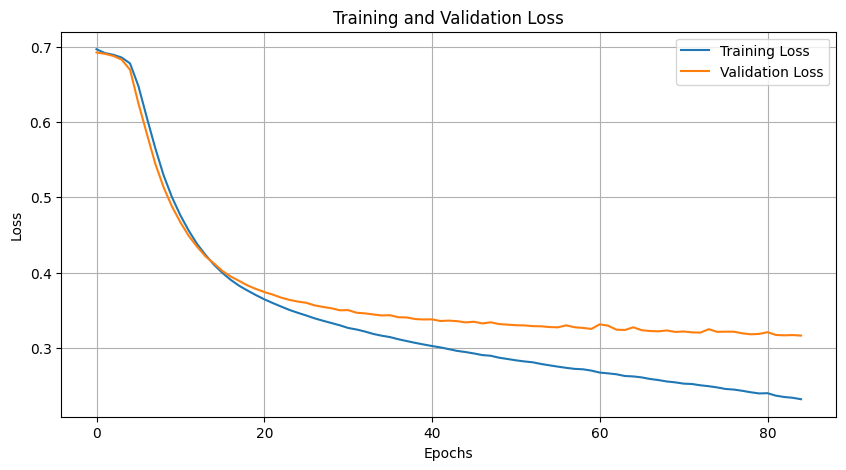

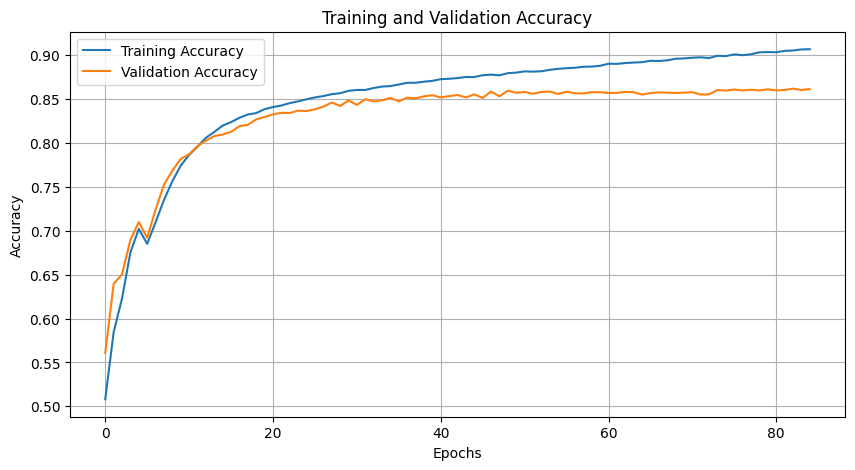

In [18]:
# Set hyperparameters
input_size = frequentWord
embedding_dim = 64
hidden_size = 64
output_size = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.0001
weight_decay = 9e-4  # Adjust weight decay here
dropout = 0.5  # Adjust dropout rate here
batch_size = 256
num_epochs = 85

# Instantiate the model and move to device
model = VanillaRNN(input_size, embedding_dim, hidden_size, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/85, Loss: 0.6929, Validation Loss: 0.6926, Train Accuracy: 0.5220, Validation Accuracy: 0.5420
Epoch 2/85, Loss: 0.6923, Validation Loss: 0.6918, Train Accuracy: 0.5731, Validation Accuracy: 0.5773
Epoch 3/85, Loss: 0.6911, Validation Loss: 0.6903, Train Accuracy: 0.6095, Validation Accuracy: 0.6580
Epoch 4/85, Loss: 0.6876, Validation Loss: 0.6840, Train Accuracy: 0.6444, Validation Accuracy: 0.6070
Epoch 5/85, Loss: 0.6732, Validation Loss: 0.6527, Train Accuracy: 0.6976, Validation Accuracy: 0.7145
Epoch 6/85, Loss: 0.6218, Validation Loss: 0.5936, Train Accuracy: 0.7130, Validation Accuracy: 0.7115
Epoch 7/85, Loss: 0.5729, Validation Loss: 0.5524, Train Accuracy: 0.7276, Validation Accuracy: 0.7360
Epoch 8/85, Loss: 0.5376, Validation Loss: 0.5224, Train Accuracy: 0.7463, Validation Accuracy: 0.7525
Epoch 9/85, Loss: 0.5087, Validation Loss: 0.4954, Train Accuracy: 0.7636, Validation Accuracy: 0.7715
Epoch 10/85, Loss: 0.4842, Validation Loss: 0.4761, Train Accuracy: 0.778

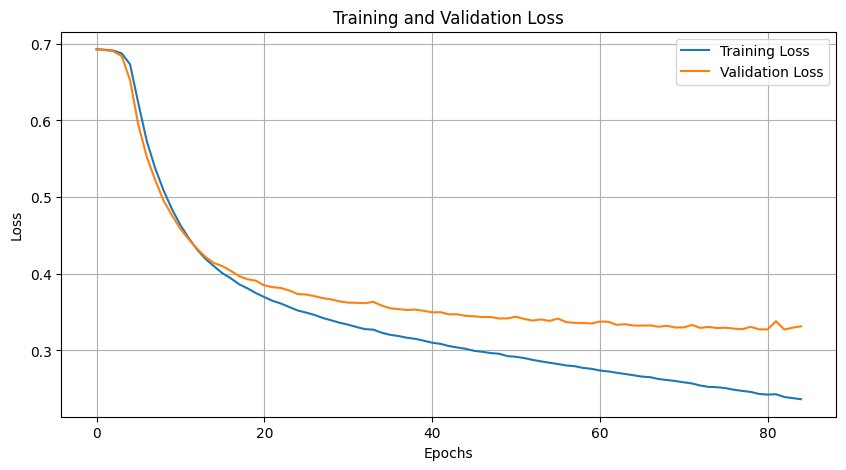

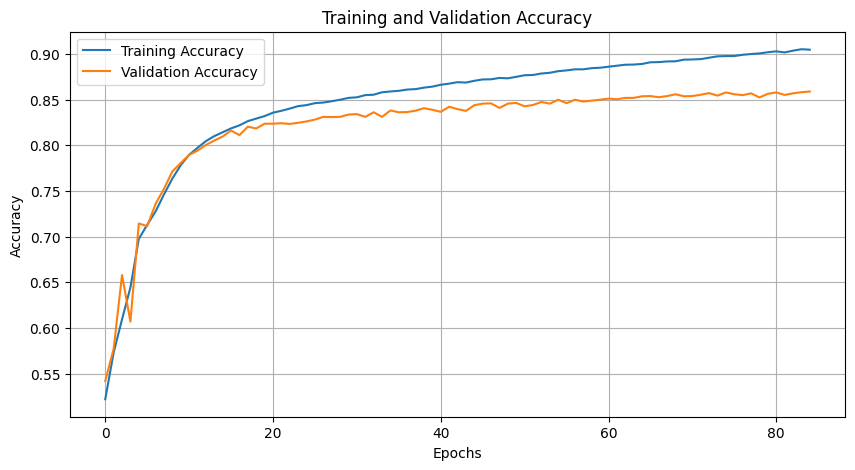

In [19]:
# Set hyperparameters
input_size = frequentWord
embedding_dim = 64
hidden_size = 64
output_size = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.0001
weight_decay = 7e-4  # Adjust weight decay here
dropout = 0.5  # Adjust dropout rate here
batch_size = 256
num_epochs = 85

# Instantiate the model and move to device
model = VanillaRNN(input_size, embedding_dim, hidden_size, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/85, Loss: 0.6926, Validation Loss: 0.6916, Train Accuracy: 0.5264, Validation Accuracy: 0.5755
Epoch 2/85, Loss: 0.6910, Validation Loss: 0.6896, Train Accuracy: 0.5914, Validation Accuracy: 0.6195
Epoch 3/85, Loss: 0.6879, Validation Loss: 0.6854, Train Accuracy: 0.6487, Validation Accuracy: 0.6867
Epoch 4/85, Loss: 0.6818, Validation Loss: 0.6761, Train Accuracy: 0.7020, Validation Accuracy: 0.7320
Epoch 5/85, Loss: 0.6579, Validation Loss: 0.6318, Train Accuracy: 0.7132, Validation Accuracy: 0.7292
Epoch 6/85, Loss: 0.6078, Validation Loss: 0.5785, Train Accuracy: 0.7321, Validation Accuracy: 0.7498
Epoch 7/85, Loss: 0.5602, Validation Loss: 0.5329, Train Accuracy: 0.7462, Validation Accuracy: 0.7628
Epoch 8/85, Loss: 0.5204, Validation Loss: 0.4983, Train Accuracy: 0.7626, Validation Accuracy: 0.7790
Epoch 9/85, Loss: 0.4911, Validation Loss: 0.4741, Train Accuracy: 0.7776, Validation Accuracy: 0.7870
Epoch 10/85, Loss: 0.4695, Validation Loss: 0.4550, Train Accuracy: 0.788

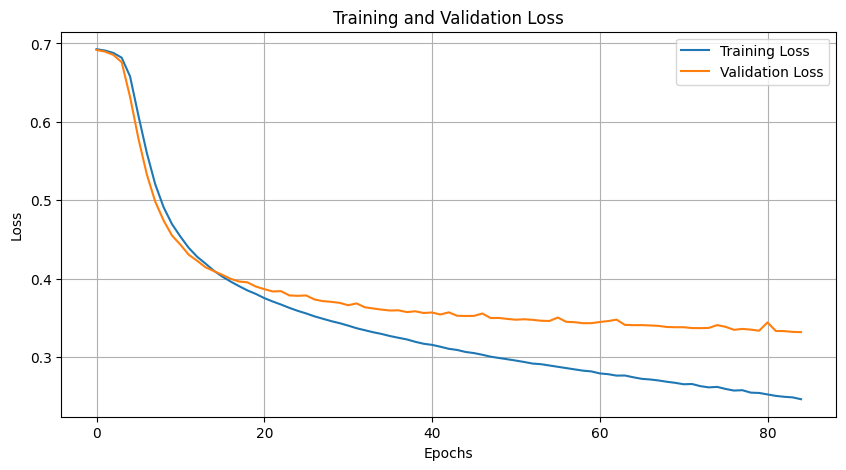

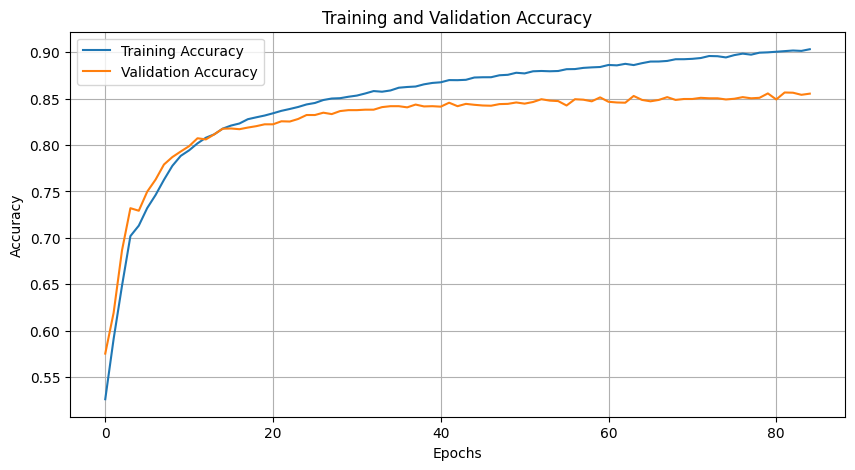

In [20]:
# Set hyperparameters
input_size = frequentWord
embedding_dim = 64
hidden_size = 64
output_size = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.0001
weight_decay = 11e-4  # Adjust weight decay here
dropout = 0.5  # Adjust dropout rate here
batch_size = 256
num_epochs = 85

# Instantiate the model and move to device
model = VanillaRNN(input_size, embedding_dim, hidden_size, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# best

Epoch 1/85, Loss: 0.6931, Validation Loss: 0.6925, Train Accuracy: 0.5146, Validation Accuracy: 0.5110
Epoch 2/85, Loss: 0.6916, Validation Loss: 0.6910, Train Accuracy: 0.5459, Validation Accuracy: 0.5370
Epoch 3/85, Loss: 0.6897, Validation Loss: 0.6884, Train Accuracy: 0.5882, Validation Accuracy: 0.6322
Epoch 4/85, Loss: 0.6865, Validation Loss: 0.6843, Train Accuracy: 0.6504, Validation Accuracy: 0.6817
Epoch 5/85, Loss: 0.6811, Validation Loss: 0.6773, Train Accuracy: 0.6936, Validation Accuracy: 0.7113
Epoch 6/85, Loss: 0.6721, Validation Loss: 0.6656, Train Accuracy: 0.7244, Validation Accuracy: 0.7322
Epoch 7/85, Loss: 0.6572, Validation Loss: 0.6470, Train Accuracy: 0.7378, Validation Accuracy: 0.7475
Epoch 8/85, Loss: 0.6361, Validation Loss: 0.6231, Train Accuracy: 0.7449, Validation Accuracy: 0.7482
Epoch 9/85, Loss: 0.6097, Validation Loss: 0.5934, Train Accuracy: 0.7497, Validation Accuracy: 0.7518
Epoch 10/85, Loss: 0.5772, Validation Loss: 0.5594, Train Accuracy: 0.755

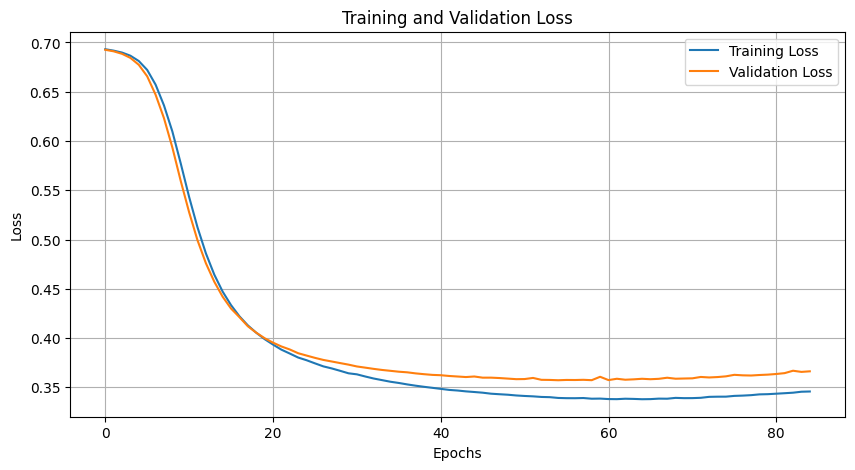

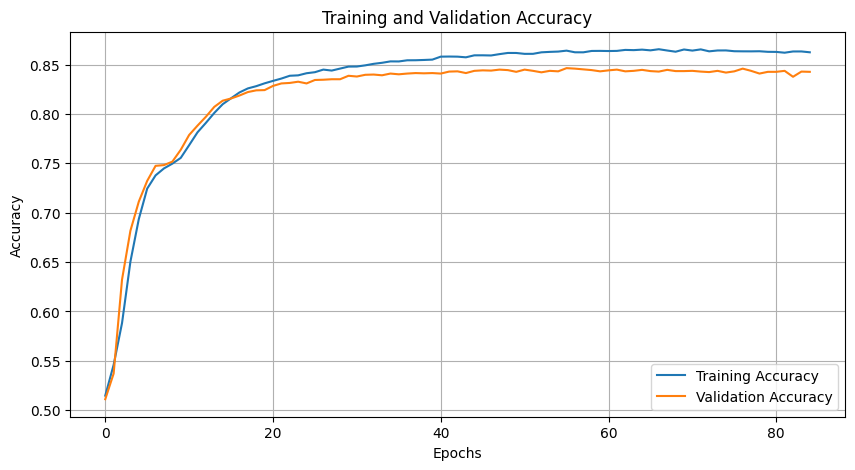

In [22]:
# Set hyperparameters
input_size = frequentWord
embedding_dim = 64
hidden_size = 64
output_size = 1  # Assuming binary classification, hence 1 output neuron
learning_rate = 0.0001
weight_decay = 11e-3  # Adjust weight decay here
dropout = 0.5  # Adjust dropout rate here
batch_size = 256
num_epochs = 85

# Instantiate the model and move to device
model = VanillaRNN(input_size, embedding_dim, hidden_size, output_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Calculate train accuracy
        preds = torch.round(outputs.squeeze())
        correct_train_predictions += torch.sum(preds == labels).item()
        total_train_predictions += labels.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train_predictions / total_train_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate validation accuracy
            preds = torch.round(outputs.squeeze())
            correct_val_predictions += torch.sum(preds == labels).item()
            total_val_predictions += labels.size(0)
            
        epoch_val_loss = val_loss / len(val_dataset)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(val_accuracy)

    print("Epoch {}/{}, Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(epoch+1, num_epochs, epoch_loss, epoch_val_loss, train_accuracy, val_accuracy))
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()